In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric-motor-temperature/measures_v2.csv


In [2]:

from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn import svm

import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from sklearn import neighbors
from math import sqrt
from sklearn.metrics import r2_score,mean_squared_error

#import the metrics 
from sklearn import metrics

from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA



The data set comprises several sensor data collected from a permanent magnet synchronous motor (PMSM) deployed on a test bench. The PMSM represents a german OEM's prototype model. Test bench measurements were collected by the LEA department at Paderborn University.

# Content
All recordings are sampled at 2 Hz. The data set consists of multiple measurement sessions, which can be distinguished from each other by column "profile_id". A measurement session can be between one and six hours long.

The motor is excited by hand-designed driving cycles denoting a reference motor speed and a reference torque.
Currents in d/q-coordinates (columns "id" and iq") and voltages in d/q-coordinates (columns "ud" and "uq") are a result of a standard control strategy trying to follow the reference speed and torque.
Columns "motor_speed" and "torque" are the resulting quantities achieved by that strategy, derived from set currents and voltages.

Most driving cycles denote random walks in the speed-torque-plane in order to imitate real world driving cycles to a more accurate degree than constant excitations and ramp-ups and -downs would.

In [3]:
df = pd.read_csv('/kaggle/input/electric-motor-temperature/measures_v2.csv')

In [4]:
df.shape

(1330816, 13)

In [5]:
df.head()

u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101          17  
1  0.000606 -0.000785  24.538078    18.314955  19.850672  0.245417          17  
2  0.001290  0.000386  24.544693    18.326307  19.850657  0.176615          17  
3  0.000026  0.002046  24.554018    18.330833  19.850647  0.238303          17  
4 -0.064317  0.037184  24.565397    18.326662  19.850639  0.208197          17

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


In [7]:
df.describe()

u_q       coolant  stator_winding           u_d  stator_tooth  \
count  1.330816e+06  1.330816e+06    1.330816e+06  1.330816e+06  1.330816e+06   
mean   5.427900e+01  3.622999e+01    6.634275e+01 -2.513381e+01  5.687858e+01   
std    4.417323e+01  2.178615e+01    2.867206e+01  6.309197e+01  2.295223e+01   
min   -2.529093e+01  1.062375e+01    1.858582e+01 -1.315304e+02  1.813398e+01   
25%    1.206992e+01  1.869814e+01    4.278796e+01 -7.869090e+01  3.841601e+01   
50%    4.893818e+01  2.690014e+01    6.511013e+01 -7.429755e+00  5.603635e+01   
75%    9.003439e+01  4.985749e+01    8.814114e+01  1.470271e+00  7.558668e+01   
max    1.330370e+02  1.015985e+02    1.413629e+02  1.314698e+02  1.119464e+02   

        motor_speed           i_d           i_q            pm   stator_yoke  \
count  1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06   
mean   2.202081e+03 -6.871681e+01  3.741278e+01  5.850678e+01  4.818796e+01   
std    1.859663e+03  6.493323e+01  9.218188e+01  1.900150e+01  1.999100e+01   
min   -2.755491e+02 -2.780036e+02 -2.934268e+02  2.085696e+01  1.807669e+01   
25%    3.171107e+02 -1.154061e+02  1.095863e+00  4.315158e+01  3.199033e+01   
50%    1.999977e+03 -5.109376e+01  1.577401e+01  6.026629e+01  4.562551e+01   
75%    3.760639e+03 -2.979688e+00  1.006121e+02  7.200837e+01  6.146083e+01   
max    6.000015e+03  5.189670e-02  3.017079e+02  1.136066e+02  1.011480e+02   

            ambient        torque    profile_id  
count  1.330816e+06  1.330816e+06  1.330816e+06  
mean   2.456526e+01  3.110603e+01  4.079306e+01  
std    1.929522e+00  7.713575e+01  2.504549e+01  
min    8.783478e+00 -2.464667e+02  2.000000e+00  
25%    2.318480e+01 -1.374265e-01  1.700000e+01  
50%    2.479733e+01  1.086035e+01  4.300000e+01  
75%    2.621702e+01  9.159718e+01  6.500000e+01  
max    3.071420e+01  2.610057e+02  8.100000e+01

In [8]:
df.isnull().sum()

u_q               0
coolant           0
stator_winding    0
u_d               0
stator_tooth      0
motor_speed       0
i_d               0
i_q               0
pm                0
stator_yoke       0
ambient           0
torque            0
profile_id        0
dtype: int64

In [9]:
df.dtypes.value_counts()

float64    12
int64       1
dtype: int64

<AxesSubplot:>

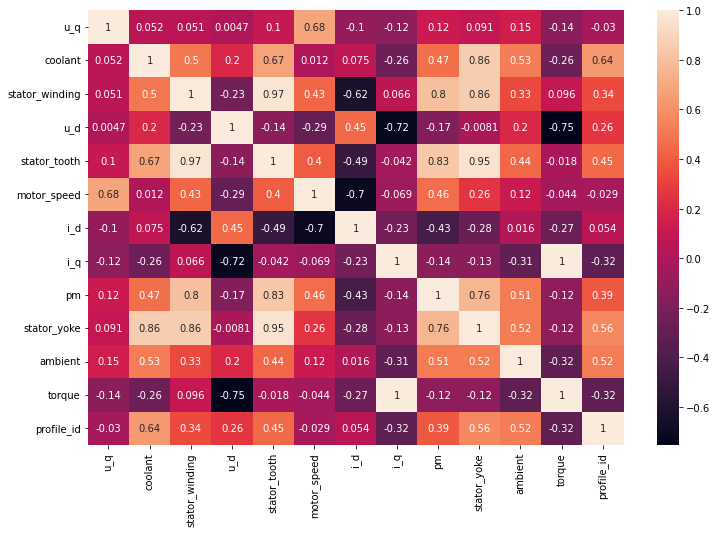

In [10]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True)

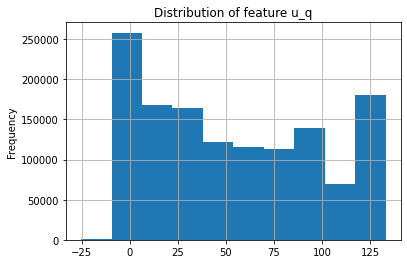

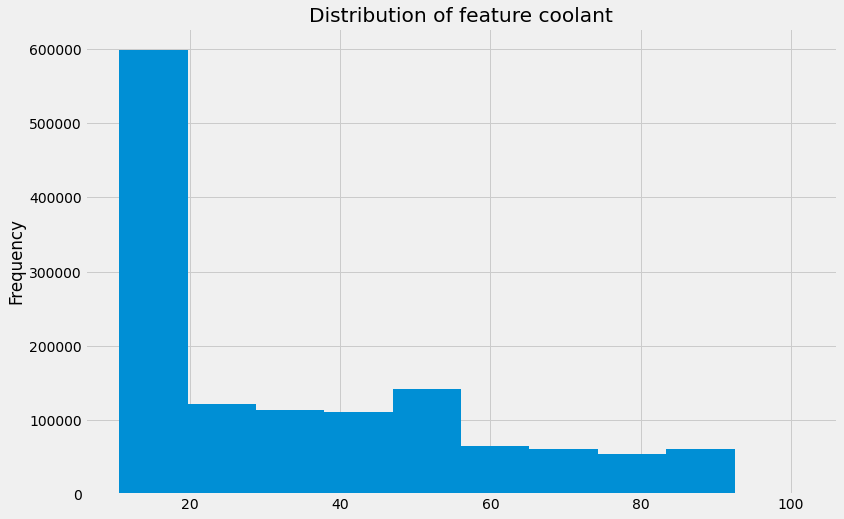

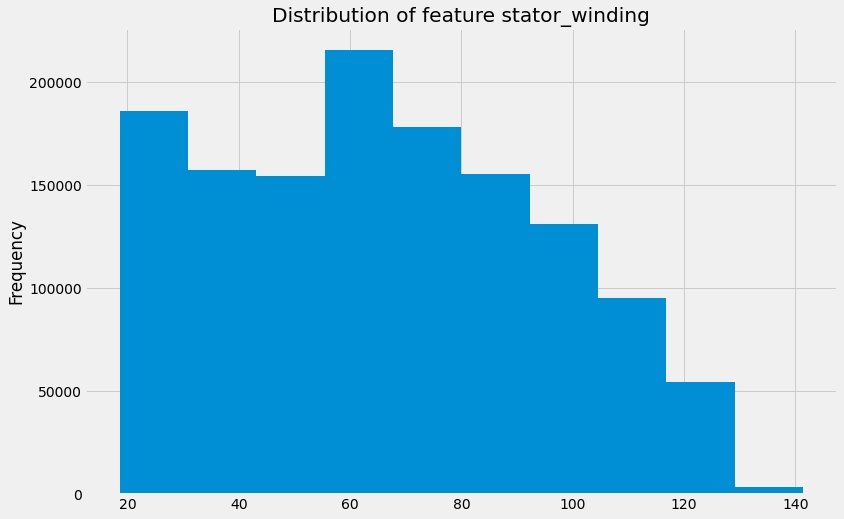

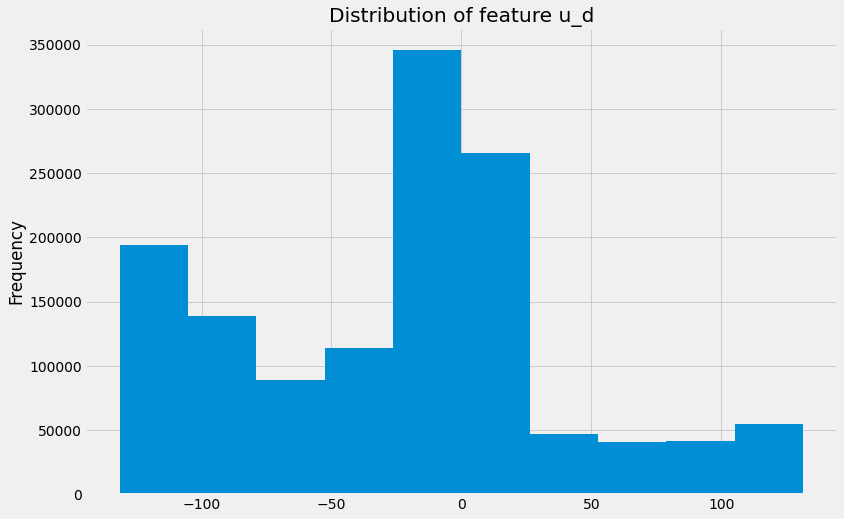

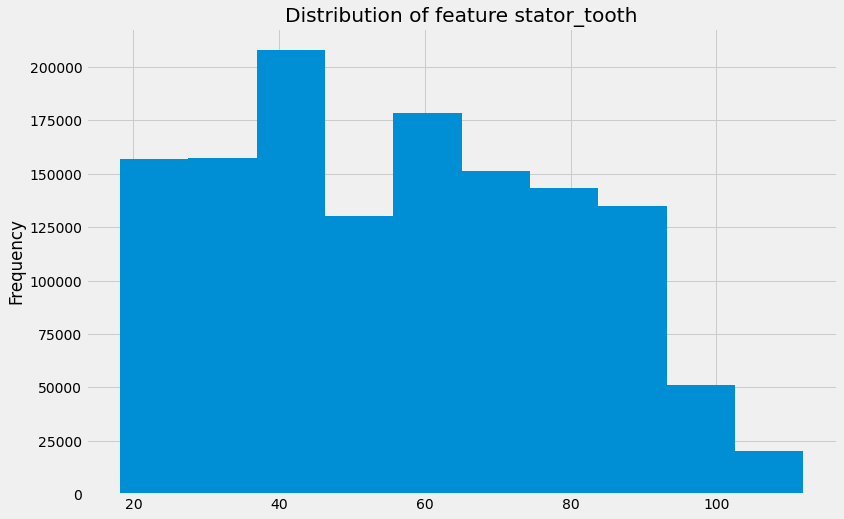

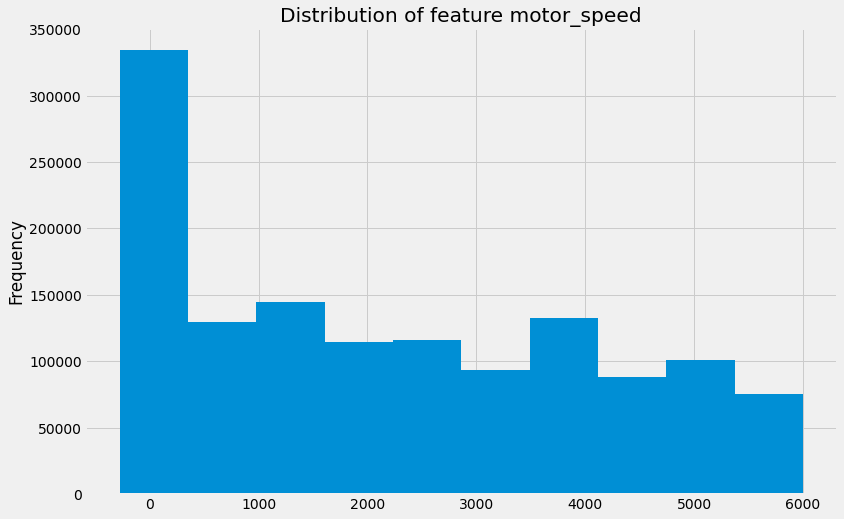

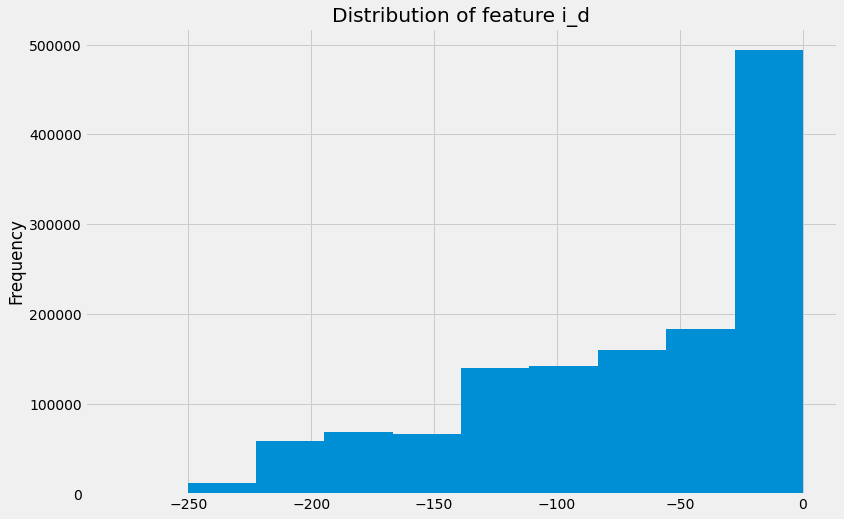

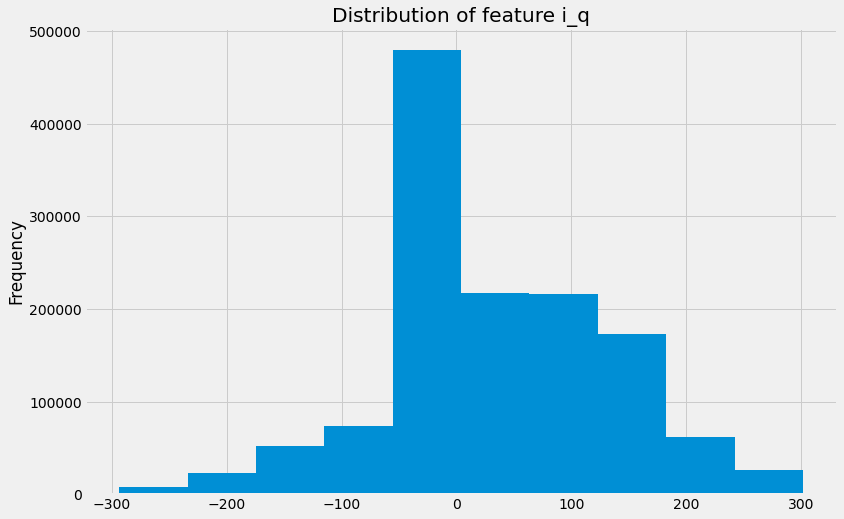

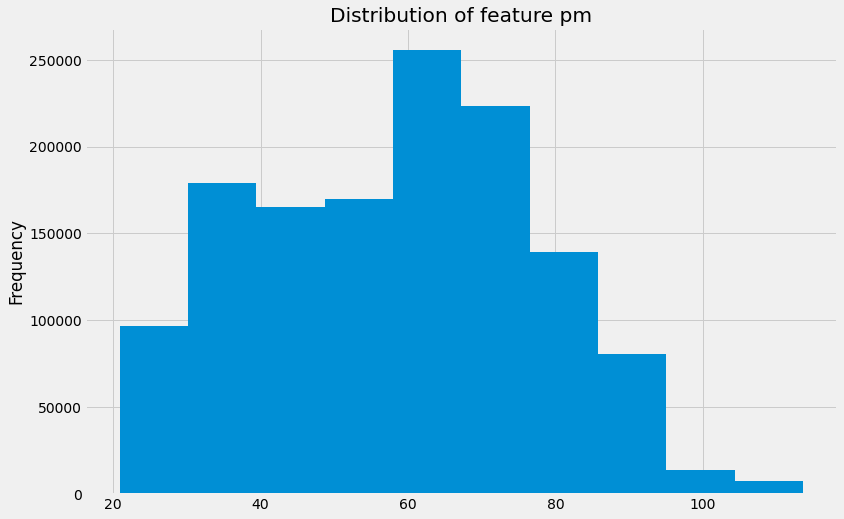

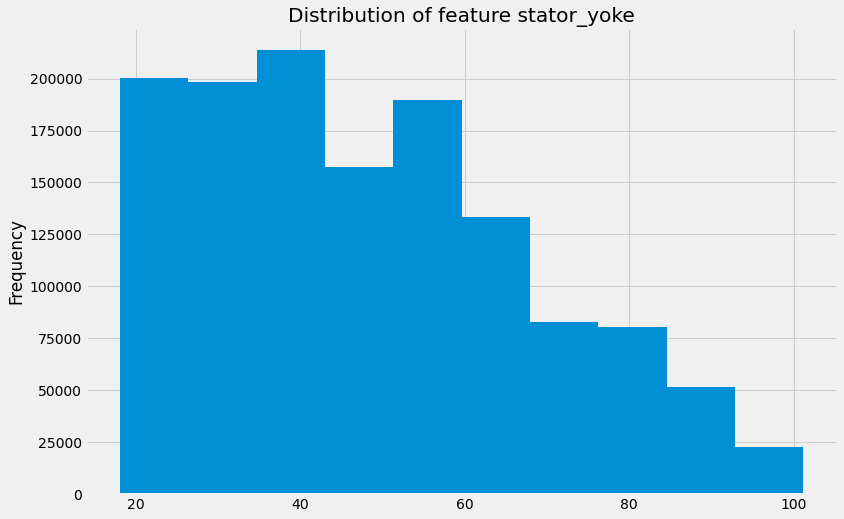

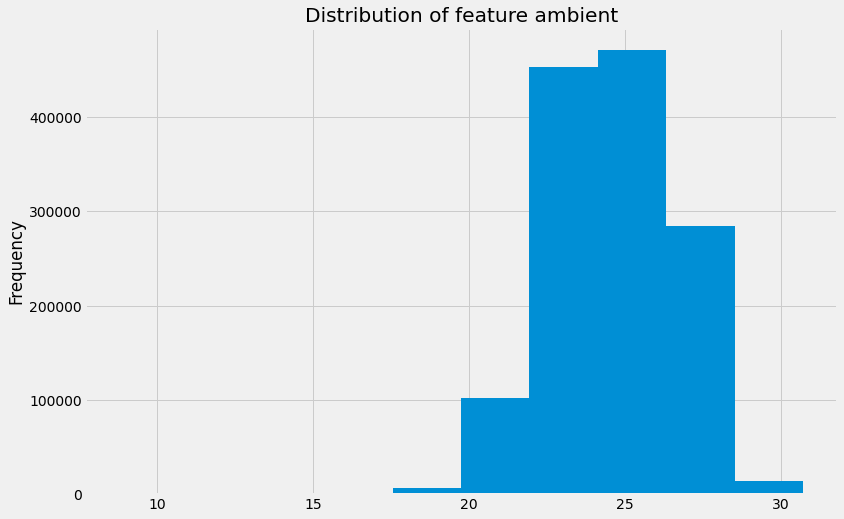

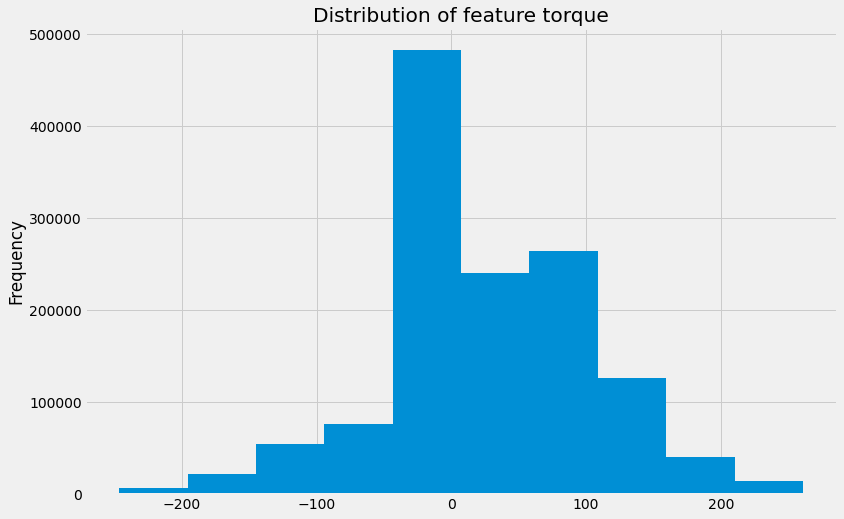

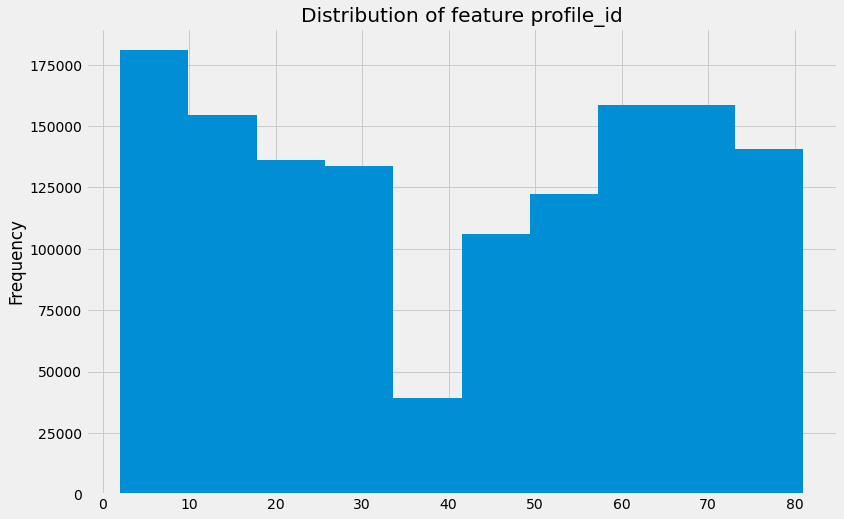

<Figure size 864x576 with 0 Axes>

In [11]:
for i in df.columns:
    plt.title(f'Distribution of feature {i}')
    plt.style.use('fivethirtyeight')
    df[i].plot(kind='hist')
    plt.figure(figsize=(12, 8))

<AxesSubplot:xlabel='ambient', ylabel='pm'>

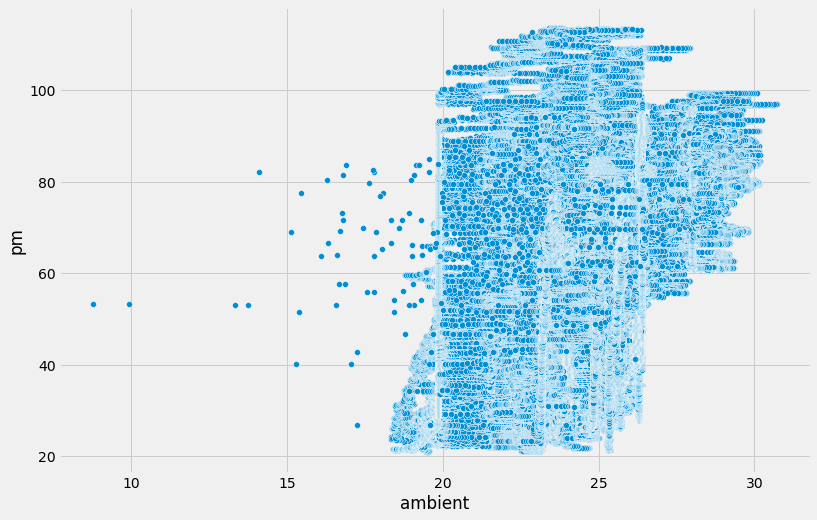

In [12]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(12, 8))
sns.scatterplot(df['ambient'],df['pm'])

<AxesSubplot:xlabel='coolant', ylabel='pm'>

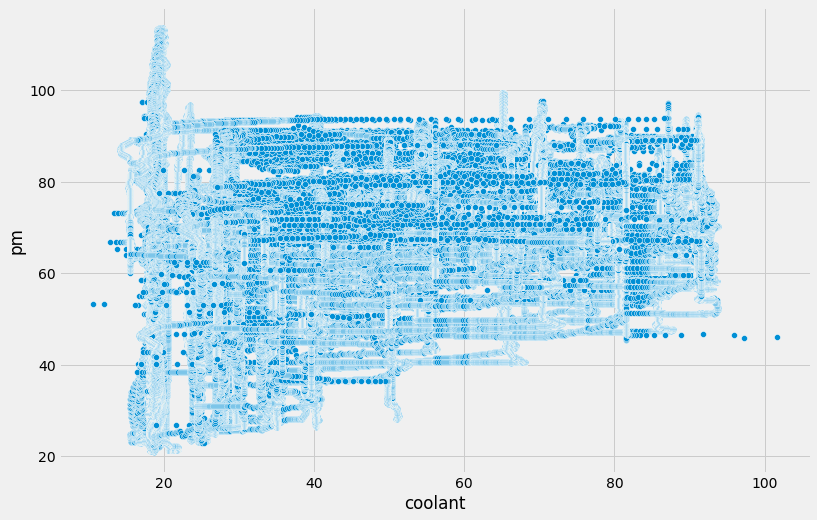

In [13]:
plt.figure(figsize=(12, 8))
sns.scatterplot(df['coolant'],df['pm'])


<AxesSubplot:xlabel='u_q', ylabel='pm'>

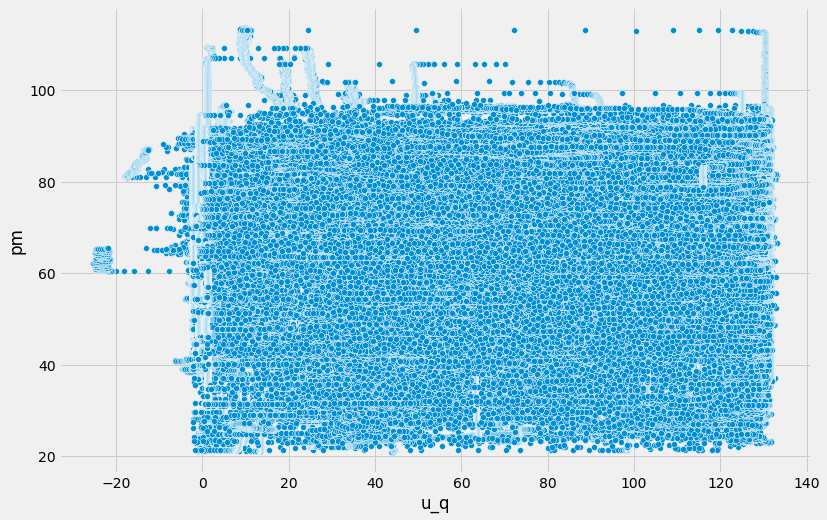

In [14]:
plt.figure(figsize=(12, 8))
sns.scatterplot(df['u_q'],df['pm'])

<AxesSubplot:xlabel='u_d', ylabel='pm'>

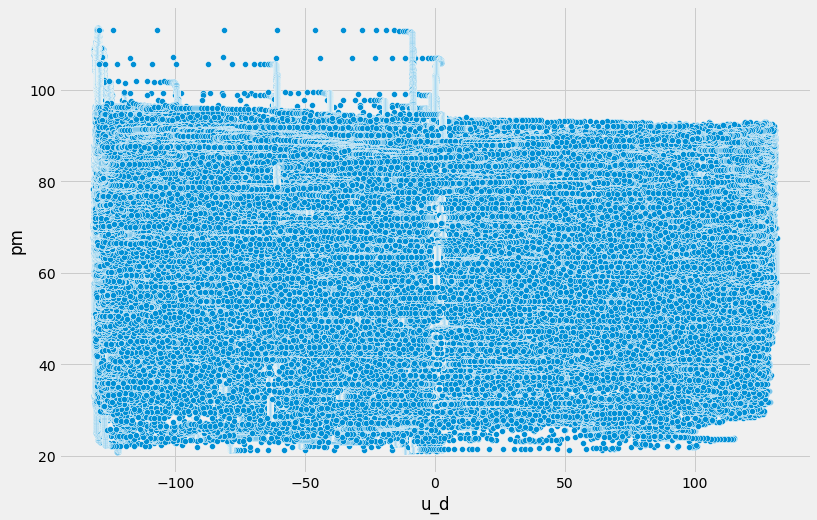

In [15]:
plt.figure(figsize=(12, 8))
sns.scatterplot(df['u_d'],df['pm'])


<AxesSubplot:xlabel='i_q', ylabel='pm'>

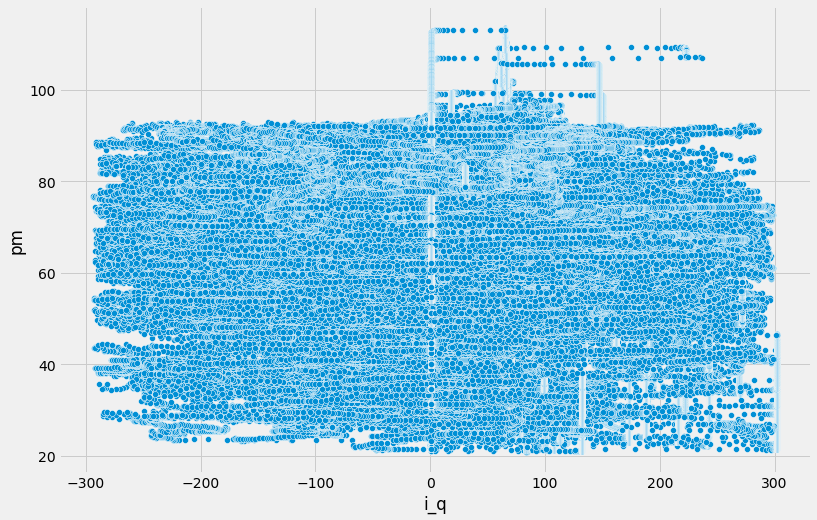

In [16]:
plt.figure(figsize=(12, 8))
sns.scatterplot(df['i_q'],df['pm'])


<AxesSubplot:xlabel='i_d', ylabel='pm'>

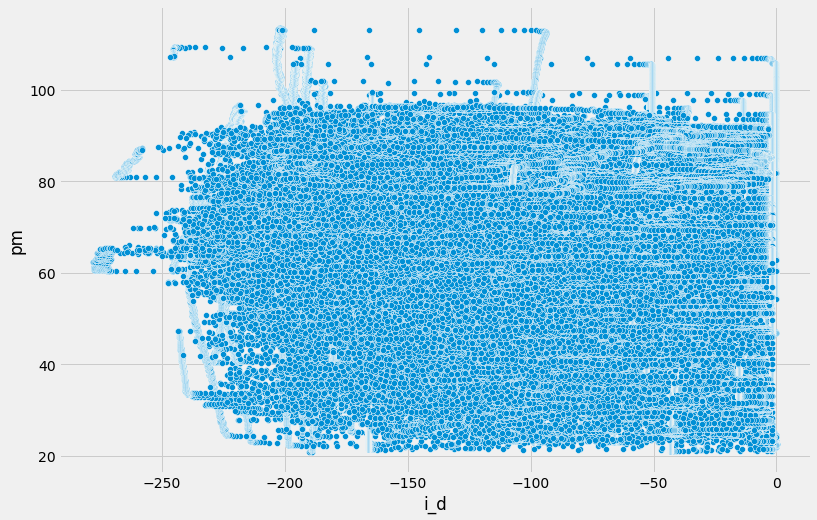

In [17]:
plt.figure(figsize=(12, 8))
sns.scatterplot(df['i_d'],df['pm'])


<AxesSubplot:xlabel='motor_speed', ylabel='pm'>

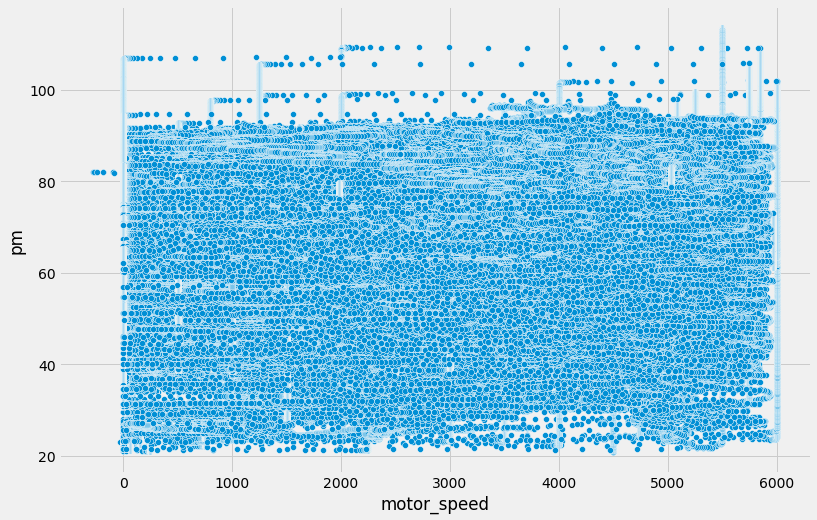

In [18]:
plt.figure(figsize=(12, 8))
sns.scatterplot(df['motor_speed'],df['pm'])


In [19]:
#not important so we will drop it from the data frame
df.drop('profile_id', axis=1, inplace=True )

In [20]:
x  = df.drop(['motor_speed'], axis=1)
y = df['motor_speed']

In [21]:
df.columns

Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque'],
      dtype='object')

In [22]:
x

u_q    coolant  stator_winding       u_d  stator_tooth  \
0       -0.450682  18.805172       19.086670 -0.350055     18.293219   
1       -0.325737  18.818571       19.092390 -0.305803     18.294807   
2       -0.440864  18.828770       19.089380 -0.372503     18.294094   
3       -0.327026  18.835567       19.083031 -0.316199     18.292542   
4       -0.471150  18.857033       19.082525 -0.332272     18.291428   
...           ...        ...             ...       ...           ...   
1330811 -2.152128  30.721298       45.274497  0.791801     41.934347   
1330812 -2.258684  30.721306       45.239017  0.778900     41.868923   
1330813 -2.130312  30.721312       45.211576  0.804914     41.804819   
1330814 -2.268498  30.721316       45.193508  0.763091     41.762220   
1330815 -2.100158  30.721319       45.132307  0.807309     41.734763   

              i_d       i_q         pm  stator_yoke    ambient        torque  
0        0.004419  0.000328  24.554214    18.316547  19.850691  1.871008e-01  
1        0.000606 -0.000785  24.538078    18.314955  19.850672  2.454175e-01  
2        0.001290  0.000386  24.544693    18.326307  19.850657  1.766153e-01  
3        0.000026  0.002046  24.554018    18.330833  19.850647  2.383027e-01  
4       -0.064317  0.037184  24.565397    18.326662  19.850639  2.081967e-01  
...           ...       ...        ...          ...        ...           ...  
1330811 -2.000169  1.097528  62.147780    38.653720  23.989078 -8.116730e-60  
1330812 -2.000499  1.097569  62.142646    38.656328  23.970700 -5.815891e-60  
1330813 -1.999268  1.098765  62.138387    38.650923  23.977234 -4.167268e-60  
1330814 -2.000999  1.095696  62.133422    38.655686  24.001421 -2.985978e-60  
1330815 -2.000792  1.096487  62.131429    38.660370  24.027522 -2.139547e-60  

[1330816 rows x 11 columns]

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score

x_train, x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=42)

training=df.copy()

In [24]:
x_train

u_q    coolant  stator_winding         u_d  stator_tooth  \
1143828  71.573058  70.094127      116.319275 -108.308071     98.257279   
213758    4.843213  23.302538      124.166260 -130.518524     92.015007   
1286043  32.323607  27.261488       74.872633  -43.099145     61.188708   
1076280  92.514180  35.819669       88.615951   92.919456     72.061041   
471043   63.622215  18.778725       39.515549  -63.737694     33.731060   
...            ...        ...             ...         ...           ...   
110268    4.161358  18.927120       19.437922    1.480744     18.633703   
259178    4.047510  19.348478      121.909668 -130.668243     89.318764   
131932   83.099945  18.485521       49.615997  -85.285301     41.744457   
671155   68.599992  86.078386      122.389794  -20.583907    103.640250   
121958   96.742744  18.985218       26.197147   -0.774760     26.384508   

                i_d         i_q         pm  stator_yoke    ambient      torque  
1143828 -147.641244   57.593952  92.632259    83.741655  26.386337   53.853077  
213758  -219.388290  113.765022  95.583832    64.013008  23.475470  110.886375  
1286043  -63.816320  169.103911  68.992171    49.245985  27.810407  131.605845  
1076280 -129.559204  -59.337778  75.580146    55.839309  26.471563  -55.032181  
471043   -43.512409  132.617157  30.649586    28.016562  21.257879  103.281677  
...             ...         ...        ...          ...        ...         ...  
110268    -2.000653    1.097256  23.047167    18.761761  22.432343    0.224484  
259178  -221.860748  114.291550  90.794975    60.657627  21.933058  111.807770  
131932   -43.514423  132.616348  47.040497    33.051914  25.016399  101.661034  
671155    -6.412302   37.039895  78.217216    93.792025  24.636226   25.082041  
121958    -2.001515    1.096187  37.513474    24.033789  23.282827   -0.290856  

[1064652 rows x 11 columns]

In [25]:
x_test

u_q    coolant  stator_winding         u_d  stator_tooth  \
294684    86.466103  65.036774      104.791176  -98.284904     91.937675   
668769    15.378630  40.755117      113.639708 -130.061039     86.672110   
1326035   68.999737  33.267112       56.794665  110.739814     50.963561   
879218    24.476531  65.758342      103.064760  -12.740853     91.052836   
75406     30.764919  18.708979      100.925667 -127.402679     73.858398   
...             ...        ...             ...         ...           ...   
403139     8.146940  18.637680       63.928745   -7.609144     45.986176   
484957    73.432289  18.866062       23.783369   -0.262001     23.820597   
1153239  122.569699  70.524754       81.434466  -47.247286     77.059755   
1065611    0.462148  35.798158       38.621466    2.701796     37.056076   
218719   131.714508  23.152214       36.362587   -2.961518     35.872459   

                i_d         i_q         pm  stator_yoke    ambient  \
294684  -132.641800   54.136551  90.431534    78.844124  25.714001   
668769  -205.998951   76.196675  81.452672    64.649777  22.844333   
1326035 -147.744392  -82.554835  67.810123    44.780991  23.684174   
879218   -15.493681   70.795574  63.638145    80.267652  24.317449   
75406   -191.776855   83.747658  73.154007    51.237759  19.926497   
...             ...         ...        ...          ...        ...   
403139   -79.941132  188.412323  38.075653    37.070152  23.026442   
484957    -2.000488    1.097368  31.692163    22.278955  23.589703   
1153239  -73.912508   31.237261  60.725853    72.121730  24.446330   
1065611   -2.000830    1.096678  48.481607    36.635349  26.384384   
218719   -45.654217    1.170167  44.456539    31.341284  23.211802   

                torque  
294684    4.751368e+01  
668769    7.500000e+01  
1326035  -7.706137e+01  
879218    5.000000e+01  
75406     8.003619e+01  
...                ...  
403139    1.550707e+02  
484957   -2.075555e-02  
1153239   2.500000e+01  
1065611 -3.705492e-320  
218719   -5.856106e-01  

[266164 rows x 11 columns]

In [26]:
x_train_scaled = scale(x_train)
x_test_scaled = scale(x_test)

In [27]:
# Define cross-validation folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)
lin_reg = LinearRegression().fit(x_train_scaled, y_train)

# Get R2 score
r2 = lin_reg.score(x_train_scaled, y_train)

lr_score = -1 * cross_val_score(lin_reg, 
                                 x_train_scaled, 
                                 y_train, 
                                 cv=cv, 
                                 scoring='neg_root_mean_squared_error')
print(lr_score)

[468.28789407 466.14172602 466.42277592 467.79828945 469.0456796
 467.83864342 470.7148133  468.02439017 467.90018135 468.10473561]


In [28]:
lr_score_train = np.mean(lr_score)
lr_score_train

468.0279128911757

In [29]:
#r2_score
r2

0.9366818753764645

In [30]:
#predict
y_predicted = lin_reg.predict(x_test_scaled)
lr_score_test = mean_squared_error(y_test, y_predicted, squared=False)
lr_score_test

468.74505079293726

In [31]:
#Lasso Regression (L1 regularization)
lasso_reg = LassoCV().fit(x_train_scaled, y_train)


# Get R2 score
lasso_reg.score(x_train_scaled, y_train)

lasso_scores = -1 * cross_val_score(lasso_reg, 
                                    x_train_scaled, 
                                    y_train, 
                                    cv=cv, 
                                    scoring='neg_root_mean_squared_error')
print(lasso_scores)

[477.54830831 476.7946451  476.12910319 477.56147256 479.2958852
 478.07091211 481.22163872 477.5112173  478.53938111 479.12491229]


In [32]:
lasso_score_train = np.mean(lasso_scores)
lasso_score_train

478.1797475907291

# Predict

In [33]:
y_predicted = lasso_reg.predict(x_test_scaled)
lasso_score_test = mean_squared_error(y_test, y_predicted, squared=False)
lasso_score_test

478.44077448290614

# Ridge Regression (L2 regularization)

In [34]:
ridge_reg = RidgeCV().fit(x_train_scaled, y_train)

In [35]:
# Get R2 score
ridge_reg.score(x_train_scaled, y_train)

0.9366818752521011

In [36]:
ridge_scores = -1 * cross_val_score(ridge_reg, 
                                    x_train_scaled, 
                                    y_train, 
                                    cv=cv, 
                                    scoring='neg_root_mean_squared_error')
print(ridge_scores)

[468.2875724  466.1418388  466.42261105 467.79819228 469.0457375
 467.83871634 470.71501109 468.02421422 467.90028851 468.10494659]


In [37]:
ridge_score_train = np.mean(ridge_scores)
print(ridge_score_train)

468.02791287844036


# Predict

In [38]:

y_predicted = ridge_reg.predict(x_test_scaled)
ridge_score_test = mean_squared_error(y_test, y_predicted, squared=False)
ridge_score_test

468.74498936737405

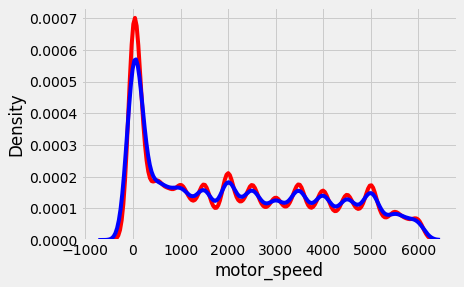

In [39]:
#Visualizing for Multiple Linear Regression y values

import seaborn as sns
ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax1);

In [40]:
pca = PCA()
x_train_pc = pca.fit_transform(x_train_scaled)

pd.DataFrame(pca.components_.T).loc[:10, :]

0         1         2         3         4         5         6   \
0   0.071140 -0.058885 -0.737120 -0.617103  0.242797 -0.010772 -0.081778   
1   0.346714 -0.164323  0.365797 -0.299072  0.321856 -0.058285  0.470821   
2   0.421409  0.169780 -0.034513  0.198385  0.125116 -0.098362 -0.247739   
3  -0.023785 -0.499306  0.058267  0.130606  0.184634 -0.544692 -0.553560   
4   0.451198  0.085503  0.024533  0.062919  0.154731 -0.003816 -0.151916   
5  -0.200197 -0.316192  0.435728 -0.442629  0.060302  0.471999 -0.378523   
6  -0.082984  0.514142  0.205704 -0.280969  0.007504 -0.209932 -0.255050   
7   0.404694  0.045541 -0.116024  0.107918 -0.290413  0.526152 -0.354413   
8   0.446339 -0.012573  0.174993 -0.090156  0.230559 -0.012269  0.028783   
9   0.278820 -0.200765  0.063447 -0.338814 -0.789029 -0.333077  0.076831   
10 -0.072770  0.526527  0.193329 -0.244811 -0.004127 -0.187953 -0.200220   

          7         8         9         10  
0   0.000966 -0.033227 -0.014955  0.015074  
1  -0.376452 -0.384184  0.023688 -0.104885  
2   0.446613 -0.593656 -0.003328  0.338285  
3  -0.301015  0.002969 -0.037934 -0.020239  
4   0.280593  0.230227  0.075511 -0.774645  
5   0.313071 -0.078437 -0.017247 -0.001299  
6  -0.164713  0.032172  0.682959  0.061132  
7  -0.563208 -0.063341 -0.008828  0.031047  
8   0.073306  0.658756 -0.080811  0.511734  
9   0.153924 -0.004978 -0.000955 -0.002118  
10 -0.134406 -0.025967 -0.720225 -0.085273

In [41]:
pca.explained_variance_ratio_

array([4.21709407e-01, 2.80852590e-01, 9.88883151e-02, 8.07620268e-02,
       5.35475512e-02, 3.10012328e-02, 2.30406038e-02, 9.43755226e-03,
       5.26487644e-04, 1.69149095e-04, 6.50850451e-05])

In [42]:
# Linear Regression
lin_reg = LinearRegression().fit(x_train_scaled, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, x_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(x_test_scaled), squared=False)

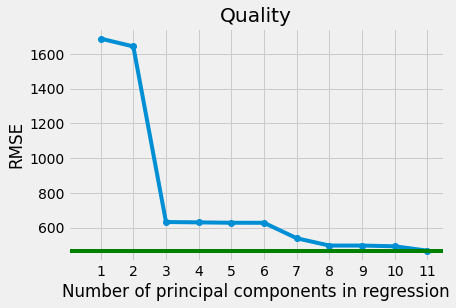

In [43]:
# Initialize linear regression instance
lin_reg2 = LinearRegression()

# Create empty list to store RMSE for each iteration
rmse_list = []

# Loop through different count of principal components for linear regression
for i in range(1, x_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg2, 
                                      x_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    
# Visual analysis - plot RMSE vs count of principal components used
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Quality')
plt.xlim(xmin=-1);
plt.xticks(np.arange(x_train_pc.shape[1]), np.arange(1, x_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

In [44]:
# Visually determine optimal number of principal components
best_pc_num = 8

# Train model with first 8 principal components
lin_reg_pc = LinearRegression().fit(x_train_pc[:,:best_pc_num], y_train)

# Get cross-validation RMSE (train set)
pcr_score_train = -1 * cross_val_score(lin_reg_pc, 
                                       x_train_pc[:,:best_pc_num], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()

# Train model on training set
lin_reg_pc = LinearRegression().fit(x_train_pc[:,:best_pc_num], y_train)

# Get first 8 principal components of test set
x_test_pc = pca.transform(x_test_scaled)[:,:best_pc_num]

# Predict on test data
preds = lin_reg_pc.predict(x_test_pc)
pcr_score_test = mean_squared_error(y_test, preds, squared=False)

In [45]:
pcr_score_test

497.53428575899505

In [46]:
train_metrics = np.array([round(lr_score_train,3), 
                          round(lasso_score_train,3), 
                          round(ridge_score_train,3), 
                          round(pcr_score_train,3)]) 
train_metrics = pd.DataFrame(train_metrics, columns=['RMSE (Train Set)'])
train_metrics.index = ['Linear Regression', 
                       'Lasso Regression', 
                       'Ridge Regression', 
                       f'PCR ({best_pc_num} components)']
train_metrics

RMSE (Train Set)
Linear Regression            468.028
Lasso Regression             478.180
Ridge Regression             468.028
PCR (8 components)           497.543

In [47]:
test_metrics = np.array([round(lr_score_test,3), 
                         round(lasso_score_test,3), 
                         round(ridge_score_test,3), 
                         round(pcr_score_test,3)]) 
test_metrics = pd.DataFrame(test_metrics, columns=['RMSE (Test Set)'])
test_metrics.index = ['Linear Regression', 
                      'Lasso Regression', 
                      'Ridge Regression', 
                      f'PCR ({best_pc_num} components)']
test_metrics

RMSE (Test Set)
Linear Regression           468.745
Lasso Regression            478.441
Ridge Regression            468.745
PCR (8 components)          497.534

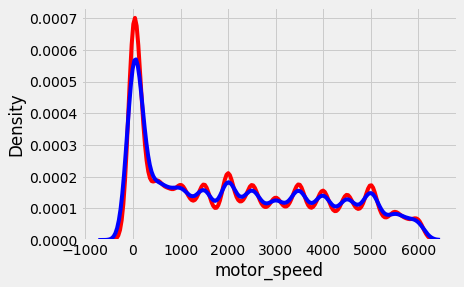

In [48]:
#Visualizing for Multiple Linear Regression y values

import seaborn as sns
ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax1);

#lets try in different way

In [49]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=100)

In [50]:
## Scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [51]:
## Training the dataset
from sklearn.linear_model import  Ridge, Lasso, LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,  AdaBoostRegressor, BaggingRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [52]:
def predict(model):
    # Define Models Name
    print('model: {}'.format(model))
    ## fitting the model
    model.fit(x_train_scaled,y_train)
    ## predicting the value
    y_pred = model.predict(x_test_scaled)
    print('R2 score',r2_score(y_test,y_pred))
    print('MAE',mean_absolute_error(y_test,y_pred))
    print('RMSE:{}'.format(np.sqrt(mean_squared_error(y_test,y_pred))))
    plt.figure(figsize=(12, 8))
    sns.distplot(y_test-y_pred)

In [53]:
import seaborn as sns
plt.figure(figsize=(12, 8))

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

model: LinearRegression()
R2 score 0.9366687461044592
MAE 342.62560351638405
RMSE:468.1575976929985


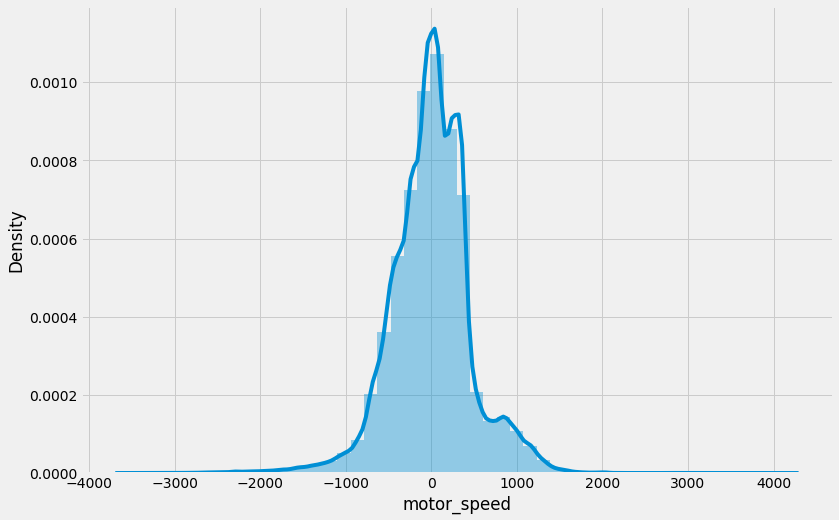

In [54]:
predict(LinearRegression())

model: Ridge()
R2 score 0.9366686424394224
MAE 342.61362790484367
RMSE:468.1579808494319


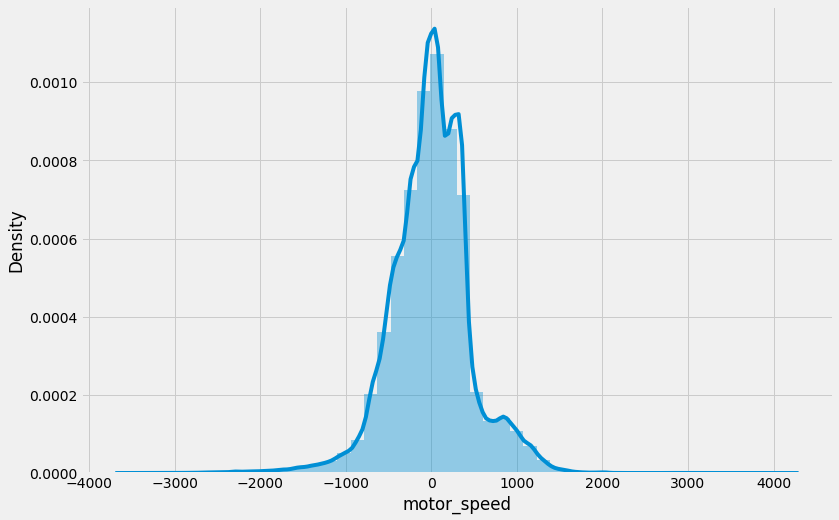

In [55]:
predict(Ridge())

model: Lasso()
R2 score 0.9345960020515041
MAE 344.34462704166765
RMSE:475.75699312555435


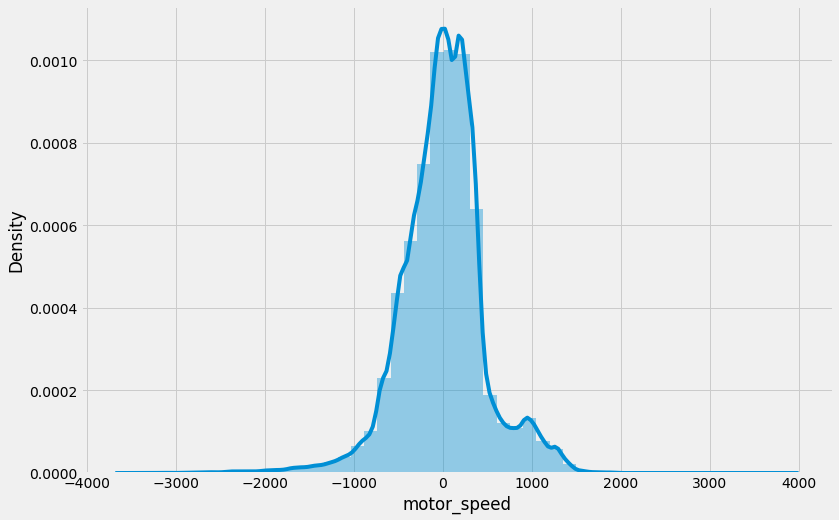

In [56]:
predict(Lasso())

model: DecisionTreeRegressor()
R2 score 0.9998089869770029
MAE 8.308937558715835
RMSE:25.710736737892805


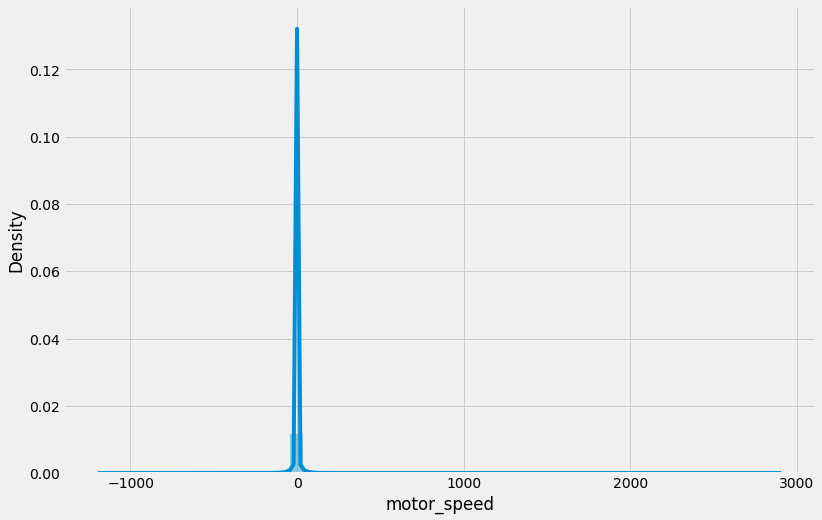

In [57]:
predict(DecisionTreeRegressor())

model: KNeighborsRegressor()
R2 score 0.9993954104725438
MAE 15.85670074788408
RMSE:45.74180968706753


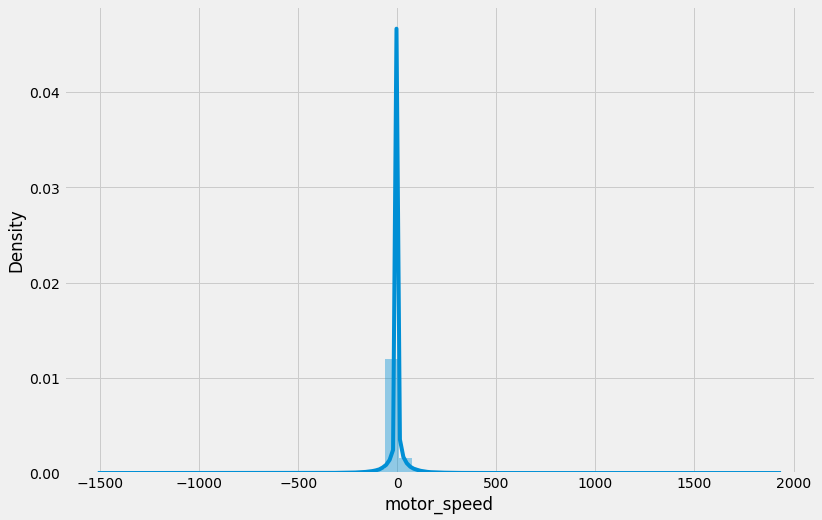

In [58]:
predict(KNeighborsRegressor())

model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)
R2 score 0.9996776994207022
MAE 15.361183996009911
RMSE:33.39747055364731


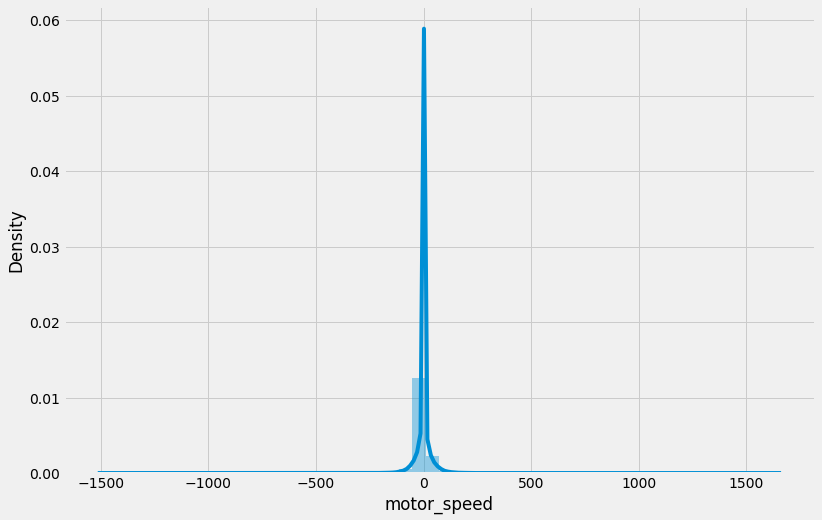

In [59]:
predict(XGBRegressor())

In [60]:
from catboost import CatBoostRegressor

cbr_model = CatBoostRegressor(n_estimators=200, 
                             loss_function='MAE',
                             eval_metric='RMSE')

cbr_model.fit(x_train, y_train)

y_predict = cbr_model.predict(x_test)
r2_score(y_test, y_predict)

0:	learn: 1823.4599152	total: 253ms	remaining: 50.3s
1:	learn: 1774.9461671	total: 402ms	remaining: 39.8s
2:	learn: 1727.0102806	total: 547ms	remaining: 35.9s
3:	learn: 1682.1368954	total: 681ms	remaining: 33.4s
4:	learn: 1639.2606798	total: 817ms	remaining: 31.9s
5:	learn: 1598.3314144	total: 964ms	remaining: 31.2s
6:	learn: 1558.0446465	total: 1.11s	remaining: 30.5s
7:	learn: 1516.9859562	total: 1.24s	remaining: 29.9s
8:	learn: 1479.1378120	total: 1.39s	remaining: 29.5s
9:	learn: 1443.0422925	total: 1.53s	remaining: 29.1s
10:	learn: 1406.6003704	total: 1.67s	remaining: 28.7s
11:	learn: 1371.3298834	total: 1.82s	remaining: 28.5s
12:	learn: 1336.4727012	total: 1.96s	remaining: 28.2s
13:	learn: 1301.9875104	total: 2.1s	remaining: 27.9s
14:	learn: 1269.6301105	total: 2.24s	remaining: 27.6s
15:	learn: 1239.6693208	total: 2.38s	remaining: 27.4s
16:	learn: 1209.8823783	total: 2.52s	remaining: 27.2s
17:	learn: 1179.2804017	total: 2.66s	remaining: 26.9s
18:	learn: 1147.2679092	total: 2.81s	re

0.9925060949010586

In [61]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler

ct =  make_column_transformer((MinMaxScaler(),['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth', 'i_d', 'i_q',
       'pm', 'stator_yoke', 'ambient', 'torque']))

In [62]:
x = df.drop(['motor_speed'], axis=1)
y = df['motor_speed']

In [63]:
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict
x_train , x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                     random_state=42)

ct.fit(x_train)

x_train_normal = ct.transform(x_train)
x_test_normal = ct.transform(x_test)

In [64]:
import tensorflow as tf
tf.random.set_seed(42)



# Build the model (3 layers, 100, 10, 1 units)
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(64),
   tf.keras.layers.Dense(32),
  tf.keras.layers.Dense(1)
])

# Compile the model
model_1.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mse'])

# Fit the model for 200 epochs (same as insurance_model_2)
history = model_1.fit(x_train_normal, y_train, epochs=10, verbose=100) 



2022-05-09 10:39:14.056399: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-05-09 10:39:14.270724: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [65]:
model_1_loss, model_1_mae = model_1.evaluate(x_test_normal, y_test)

8318/8318 [==============================] - 13s 2ms/step - loss: 311.1710 - mse: 306821.6562


In [66]:

# Compare modelling results from non-normalized data and normalized data
model_1_loss , model_1_mae

(311.1710205078125, 306821.65625)

In [67]:
# Check out our second model's architecture
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 9,777
Trainable params: 9,777
Non-trainable params: 0
_________________________________________________________________
